In [1]:
import pandas as pd
import numpy as np
import os
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

/Users/hannicho19/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from matplotlib.pyplot import *
from IPython.display import display, HTML
import glob
from anndata import AnnData

In [3]:
cd /Users/hannicho19/Desktop

/Users/hannicho19/Desktop


In [4]:
# read in the file
file = "/Users/hannicho19/Desktop/D52.h5"
adata = sc.read(file)

In [6]:
adata.n_obs

523094

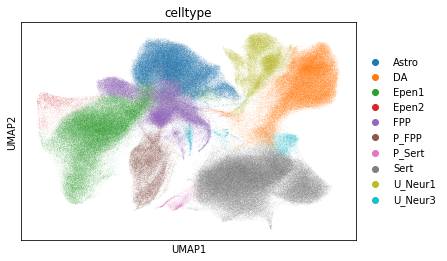

In [6]:
# since this data has been already clustered and annotated- let's plot the umap plot 
plotting_fcn = sc.pl.umap
plotting_fcn(adata, color='celltype')

In [8]:
#let's subset a specific celltype 
#subsample celltype
selected_celltype = ['Astro']
adata_As = adata[adata.obs['celltype'].isin(selected_celltype),: ]
adata_As

View of AnnData object with n_obs × n_vars = 85451 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    uns: 'celltype_colors'
    obsm: 'X_umap'

In [10]:
selected_tr = ['NONE']
adata_As2 = adata_As[adata_As.obs['treatment'].isin(selected_tr),: ]
adata_As2

View of AnnData object with n_obs × n_vars = 44059 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    uns: 'celltype_colors'
    obsm: 'X_umap'

In [22]:
adata_As.obs['treatment']

index
AAACCTGAGAAAGTGG-1-0     NONE
AAACCTGAGGTGCTTT-1-0     NONE
AAACCTGGTGTGAATA-1-0     NONE
AAACCTGGTGTTTGTG-1-0     NONE
AAACGGGAGAATGTGT-1-0     NONE
                         ... 
TTGCGTCGTCATATCG-1-78     ROT
TTGGAACTCTCACATT-1-78     ROT
TTTACTGAGTTGCAGG-1-78     ROT
TTTATGCGTTCCACAA-1-78     ROT
TTTCCTCTCGGTTAAC-1-78     ROT
Name: treatment, Length: 85451, dtype: category
Categories (2, object): ['NONE', 'ROT']

In [11]:
# step1.calclate qc metrics 
adata_As2.var['mito'] = [x.startswith('MT-') for x in adata.var.index] 
sc.pp.calculate_qc_metrics(adata_As2, inplace=True, qc_vars=['mito'])

Trying to set attribute `.var` of view, copying.


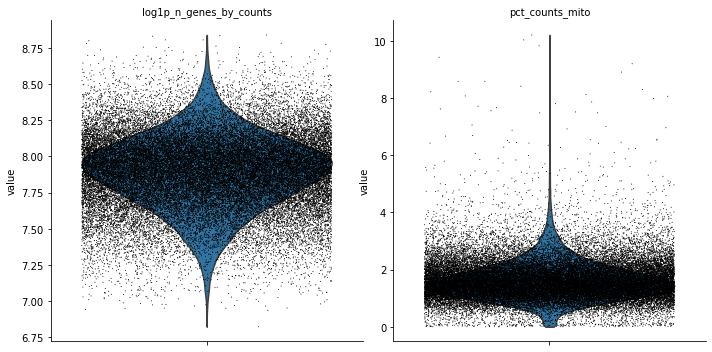

In [12]:
# step2. plotting the qc metrics
sc.pl.violin(adata_As2, ['log1p_n_genes_by_counts',  'pct_counts_mito'],
            jitter=0.4, multi_panel=True)

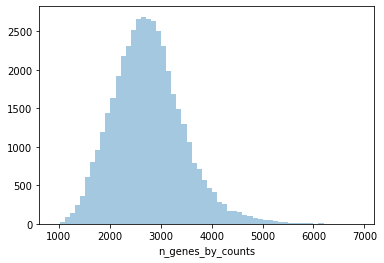

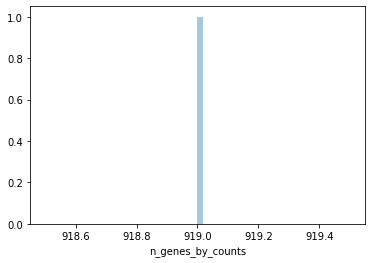

In [13]:
#step 3.we come up with thresholding decsions for genes for the FPP cells

p6 = sb.distplot(adata_As2.obs['n_genes_by_counts'], kde=False, bins=60)
plt.show()

# there seems to be a small population of cells expressing low (1000 gene) count, let's zoom in

p7 = sb.distplot(adata_As2.obs['n_genes_by_counts'][adata_As2.obs['n_genes_by_counts']<1000], kde=False, bins=60)
plt.show()

In [14]:
#QC 2 - cell level - remove cells with high mito fraction

print('Number of cells before MT filter: {:d}'.format(adata_As2.n_obs))
adata_As2 = adata_As2[adata_As2.obs['pct_counts_mito'] < 5]
print('Number of cells after MT filter: {:d}'.format(adata_As2.n_obs))



Number of cells before MT filter: 44059
Number of cells after MT filter: 43940


In [15]:
#QC -3 - gene level

#Filter genes that are not expressed in more than 20 cells in the DA cells
print('Total number of genes: {:d}'.format(adata_As2.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_As2, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata_As2.n_vars))

Total number of genes: 32738


Trying to set attribute `.var` of view, copying.


Number of genes after cell filter: 19777


In [16]:
# normalization 
# The simplest way to normalize this data is to convert it to counts per million (CPM) by dividing each row by a size factor (the sum of all counts in the row), then multiplying by 1,000,000. Note that this method assumes that each cell originally contained the same amount of RNA.
adata_As2_cpm = adata_As2.copy() # apply this to a copy so we can compare methods
adata_As2_cpm.raw = adata_As2_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_As2_cpm, 
                         counts_per_cell_after=1e6)



In [17]:
# log transformation 
sc.pp.log1p(adata_As2_cpm)
adata_As2_cpm

AnnData object with n_obs × n_vars = 43940 × 19777
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'celltype_colors', 'log1p'
    obsm: 'X_umap'

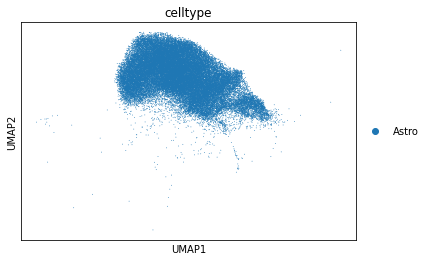

In [18]:
# plotting a umap
plotting_fcn = sc.pl.umap
plotting_fcn(adata_As2_cpm, color='celltype')

In [19]:
# aggregate the normalized and log-transformed data for per gene per individual

means = pd.DataFrame(index=adata_As2_cpm.var_names)
for k, indices in adata_As2.obs.groupby("donor_id").indices.items():
    means[k] = np.ravel(adata_As2_cpm.X[indices].mean(axis=0))
    

In [20]:
df = means
df

HPSI0114i-bezi_3  HPSI0114i-eipl_1  HPSI0114i-fikt_3  \
index                                                                 
RP11-34P13.7                0.0          0.005210          0.000000   
AL627309.1                  0.0          0.043236          0.000000   
AP006222.2                  0.0          1.671741          1.074891   
RP4-669L17.10               0.0          0.023056          0.000000   
RP11-206L10.3               0.0          0.051946          0.000000   
...                         ...               ...               ...   
AL592183.1                  0.0          0.006778          0.514722   
AC011841.1                  0.0          0.011349          0.000000   
AL354822.1                  0.0          0.000000          0.000000   
PNRC2-1                     0.0          0.036524          0.000000   
SRSF10-1                    0.0          0.671258          0.560168   

               HPSI0114i-kolf_2  HPSI0114i-lexy_2  HPSI0114i-posc_1  \
index                                                                 
RP11-34P13.7           0.000000          0.000000          0.000000   
AL627309.1             0.000000          0.000000          0.000000   
AP006222.2             1.434590          0.836476          5.573668   
RP4-669L17.10          0.025103          0.000000          0.000000   
RP11-206L10.3          0.000000          0.000000          0.000000   
...                         ...               ...               ...   
AL592183.1             0.059195          0.000000          5.573668   
AC011841.1             0.000000          0.000000          0.000000   
AL354822.1             0.000000          0.000000          0.000000   
PNRC2-1                0.000000          0.000000          0.000000   
SRSF10-1               0.028486          0.770721          0.000000   

               HPSI0114i-rozh_4  HPSI0114i-vass_1  HPSI0114i-wegi_1  \
index                                                                 
RP11-34P13.7           0.000000          0.000000          0.000000   
AL627309.1             0.000000          0.000000          0.000000   
AP006222.2             1.098987          1.699091          2.297729   
RP4-669L17.10          0.000000          0.000000          0.000000   
RP11-206L10.3          0.000000          0.000000          0.000000   
...                         ...               ...               ...   
AL592183.1             2.756008          0.000000          0.314303   
AC011841.1             0.277810          0.000000          0.000000   
AL354822.1             0.000000          0.000000          0.000000   
PNRC2-1                0.000000          0.000000          0.000000   
SRSF10-1               0.556152          0.000000          0.314303   

               HPSI0114i-zapk_2  ...  HPSI1113i-bima_1  HPSI1113i-hayt_3  \
index                            ...                                       
RP11-34P13.7           0.000000  ...          0.000000          0.000000   
AL627309.1             0.033419  ...          0.146576          0.000000   
AP006222.2             1.591703  ...          0.933928          0.491548   
RP4-669L17.10          0.000000  ...          0.000000          0.000000   
RP11-206L10.3          0.029444  ...          0.131156          0.000000   
...                         ...  ...               ...               ...   
AL592183.1             0.591102  ...          0.444015          0.110930   
AC011841.1             0.030313  ...          0.000000          0.000000   
AL354822.1             0.000000  ...          0.000000          0.000000   
PNRC2-1                0.013313  ...          0.000000          0.000000   
SRSF10-1               0.640052  ...          0.405261          0.463552   

               HPSI1113i-podx_1  HPSI1113i-qolg_1  HPSI1113i-qorq_1  \
index                                                                 
RP11-34P13.7           0.000000          0.000000          0.053837   
AL627309.1             0.000000          

In [21]:
df.to_csv("Astro_no_treament.csv")

In [24]:
selected_tr = ['ROT']
adata_Asr = adata_As[adata_As.obs['treatment'].isin(selected_tr),: ]
adata_Asr

View of AnnData object with n_obs × n_vars = 41392 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    uns: 'celltype_colors'
    obsm: 'X_umap'

In [25]:
# step1.calclate qc metrics 
adata_Asr.var['mito'] = [x.startswith('MT-') for x in adata.var.index] 
sc.pp.calculate_qc_metrics(adata_Asr, inplace=True, qc_vars=['mito'])

Trying to set attribute `.var` of view, copying.


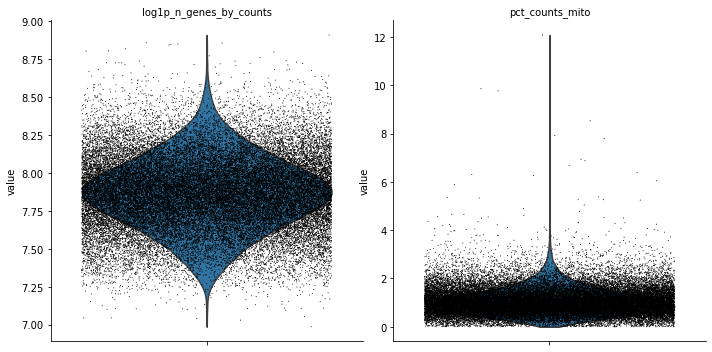

In [26]:
# step2. plotting the qc metrics
sc.pl.violin(adata_Asr, ['log1p_n_genes_by_counts',  'pct_counts_mito'],
            jitter=0.4, multi_panel=True)

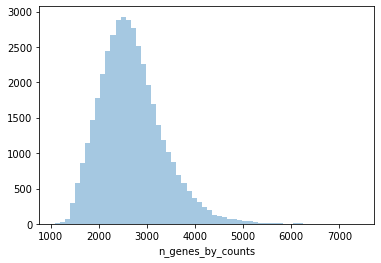

In [28]:
#step 3.we come up with thresholding decsions for genes for the FPP cells

p6 = sb.distplot(adata_Asr.obs['n_genes_by_counts'], kde=False, bins=60)
plt.show()

# there seems to be a small population of cells expressing low (1000 gene) count, let's zoom in

#p7 = sb.distplot(adata_Asr.obs['n_genes_by_counts'][adata_Asr.obs['n_genes_by_counts']<1000], kde=False, bins=60)
#plt.show()

In [29]:
#QC 2 - cell level - remove cells with high mito fraction

print('Number of cells before MT filter: {:d}'.format(adata_Asr.n_obs))
adata_Asr = adata_Asr[adata_Asr.obs['pct_counts_mito'] < 5]
print('Number of cells after MT filter: {:d}'.format(adata_Asr.n_obs))



Number of cells before MT filter: 41392
Number of cells after MT filter: 41371


In [30]:
#QC -3 - gene level

#Filter genes that are not expressed in more than 20 cells in the DA cells
print('Total number of genes: {:d}'.format(adata_Asr.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_Asr, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata_Asr.n_vars))

Total number of genes: 32738


Trying to set attribute `.var` of view, copying.


Number of genes after cell filter: 19568


In [31]:
# normalization 
# The simplest way to normalize this data is to convert it to counts per million (CPM) by dividing each row by a size factor (the sum of all counts in the row), then multiplying by 1,000,000. Note that this method assumes that each cell originally contained the same amount of RNA.
adata_Asr_cpm = adata_Asr.copy() # apply this to a copy so we can compare methods
adata_Asr_cpm.raw = adata_Asr_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_Asr_cpm, 
                         counts_per_cell_after=1e6)



In [32]:
# log transformation 
sc.pp.log1p(adata_Asr_cpm)
adata_Asr_cpm

AnnData object with n_obs × n_vars = 41371 × 19568
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'celltype_colors', 'log1p'
    obsm: 'X_umap'

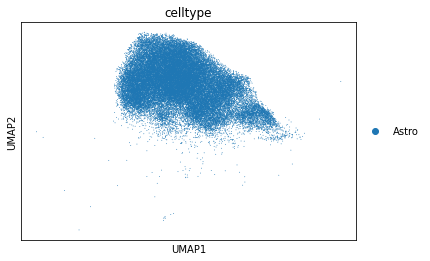

In [33]:
# plotting a umap
plotting_fcn = sc.pl.umap
plotting_fcn(adata_Asr_cpm, color='celltype')

In [34]:
# aggregate the normalized and log-transformed data for per gene per individual

means = pd.DataFrame(index=adata_Asr_cpm.var_names)
for k, indices in adata_Asr.obs.groupby("donor_id").indices.items():
    means[k] = np.ravel(adata_Asr_cpm.X[indices].mean(axis=0))
    

In [35]:
df = means
df

HPSI0114i-bezi_3  HPSI0114i-eipl_1  HPSI0114i-fikt_3  \
index                                                                 
RP11-34P13.7           0.000000          0.001917          0.000000   
AL627309.1             0.000000          0.056786          0.000000   
AP006222.2             1.248146          1.422848          1.515570   
RP4-669L17.10          0.000000          0.015436          0.185023   
RP11-206L10.3          0.000000          0.111442          0.000000   
...                         ...               ...               ...   
AL592183.1             1.076550          0.008180          0.000000   
AC011841.1             0.000000          0.001943          0.000000   
AL354822.1             0.000000          0.000000          0.000000   
PNRC2-1                0.000000          0.031716          0.000000   
SRSF10-1               0.000000          0.390334          0.526368   

               HPSI0114i-kolf_2  HPSI0114i-lexy_2  HPSI0114i-posc_1  \
index                                                                 
RP11-34P13.7           0.000000          0.000000               0.0   
AL627309.1             0.000000          0.000000               0.0   
AP006222.2             1.522644          0.366198               0.0   
RP4-669L17.10          0.000000          0.000000               0.0   
RP11-206L10.3          0.112569          0.000000               0.0   
...                         ...               ...               ...   
AL592183.1             0.112397          0.000000               0.0   
AC011841.1             0.000000          0.000000               0.0   
AL354822.1             0.000000          0.000000               0.0   
PNRC2-1                0.000000          0.353695               0.0   
SRSF10-1               0.054990          0.392333               0.0   

               HPSI0114i-rozh_4  HPSI0114i-vass_1  HPSI0114i-wegi_1  \
index                                                                 
RP11-34P13.7           0.000000          0.000000          0.000000   
AL627309.1             0.000000          0.000000          0.000000   
AP006222.2             1.714831          4.336325          1.147741   
RP4-669L17.10          0.000000          0.000000          0.000000   
RP11-206L10.3          0.000000          0.000000          0.000000   
...                         ...               ...               ...   
AL592183.1             1.070100          0.000000          0.000000   
AC011841.1             0.000000          0.000000          0.000000   
AL354822.1             0.000000          0.000000          0.000000   
PNRC2-1                0.000000          0.000000          0.000000   
SRSF10-1               0.000000          0.000000          0.000000   

               HPSI0114i-zapk_2  ...  HPSI1113i-bima_1  HPSI1113i-hayt_3  \
index                            ...                                       
RP11-34P13.7           0.000000  ...          0.000000          0.000000   
AL627309.1             0.047578  ...          0.000000          0.196024   
AP006222.2             1.735880  ...          0.644394          0.963055   
RP4-669L17.10          0.016253  ...          0.000000          0.000000   
RP11-206L10.3          0.033793  ...          0.000000          0.000000   
...                         ...  ...               ...               ...   
AL592183.1             0.988479  ...          0.298163          1.155167   
AC011841.1             0.000000  ...          0.000000          0.000000   
AL354822.1             0.000000  ...          0.000000          0.000000   
PNRC2-1                0.011523  ...          0.000000          0.000000   
SRSF10-1               0.641521  ...          0.000000          0.533671   

               HPSI1113i-ieki_3  HPSI1113i-podx_1  HPSI1113i-qolg_1  \
index                                                                 
RP11-34P13.7            0.00000          0.000000          0.000000   
AL627309.1              0.00000          

In [36]:
df.to_csv("Astro_ROT.csv")

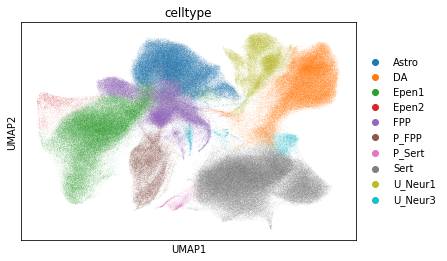

In [37]:
# now let's do the same for the other cell type - PFPP
# since this data has been already clustered and annotated- let's plot the umap plot 
plotting_fcn = sc.pl.umap
plotting_fcn(adata, color='celltype')

In [40]:
#let's subset a specific celltype 
#subsample celltype
selected_celltype = ['DA']
adata_DA = adata[adata.obs['celltype'].isin(selected_celltype),: ]
adata_DA

View of AnnData object with n_obs × n_vars = 79801 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    uns: 'celltype_colors'
    obsm: 'X_umap'

In [41]:
selected_tr = ['NONE']
adata_DA = adata_DA[adata_DA.obs['treatment'].isin(selected_tr),: ]
adata_DA

View of AnnData object with n_obs × n_vars = 54331 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    uns: 'celltype_colors'
    obsm: 'X_umap'

In [42]:
# step1.calclate qc metrics 
adata_DA.var['mito'] = [x.startswith('MT-') for x in adata.var.index] 
sc.pp.calculate_qc_metrics(adata_DA, inplace=True, qc_vars=['mito'])

Trying to set attribute `.var` of view, copying.


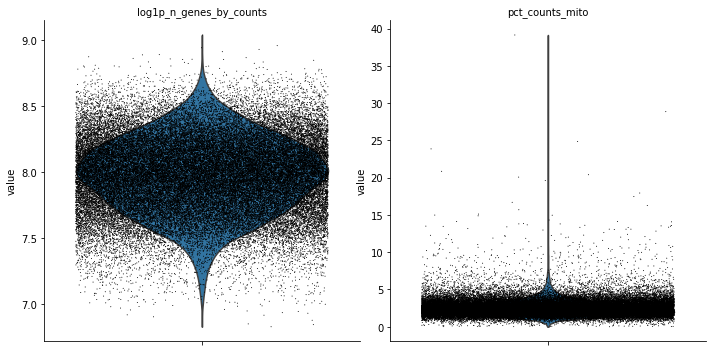

In [43]:
# step2. plotting the qc metrics
sc.pl.violin(adata_DA, ['log1p_n_genes_by_counts',  'pct_counts_mito'],
            jitter=0.4, multi_panel=True)

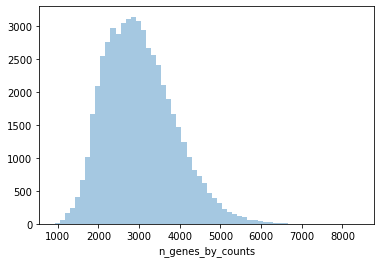

In [44]:
#step 3.we come up with thresholding decsions for genes for the FPP cells

p6 = sb.distplot(adata_DA.obs['n_genes_by_counts'], kde=False, bins=60)
plt.show()



In [45]:
#QC 2 - cell level - remove cells with high mito fraction

print('Number of cells before MT filter: {:d}'.format(adata_DA.n_obs))
adata_DA = adata_DA[adata_DA.obs['pct_counts_mito'] < 5]
print('Number of cells after MT filter: {:d}'.format(adata_DA.n_obs))



Number of cells before MT filter: 54331
Number of cells after MT filter: 52959


In [46]:
#QC -3 - gene level

#Filter genes that are not expressed in more than 20 cells in the DA cells
print('Total number of genes: {:d}'.format(adata_DA.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_DA, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata_DA.n_vars))

Total number of genes: 32738


Trying to set attribute `.var` of view, copying.


Number of genes after cell filter: 20577


In [47]:
# normalization 
# The simplest way to normalize this data is to convert it to counts per million (CPM) by dividing each row by a size factor (the sum of all counts in the row), then multiplying by 1,000,000. Note that this method assumes that each cell originally contained the same amount of RNA.
adata_DA_cpm = adata_DA.copy() # apply this to a copy so we can compare methods
adata_DA_cpm.raw = adata_DA_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_DA_cpm, 
                         counts_per_cell_after=1e6)

In [48]:
# log transformation 
sc.pp.log1p(adata_DA_cpm)
adata_DA_cpm

AnnData object with n_obs × n_vars = 52959 × 20577
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'celltype_colors', 'log1p'
    obsm: 'X_umap'

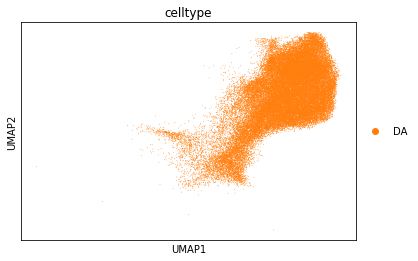

In [49]:
# plotting a umap
plotting_fcn = sc.pl.umap
plotting_fcn(adata_DA_cpm, color='celltype')

In [50]:
# aggregate the normalized and log-transformed data for per gene per individual

means = pd.DataFrame(index=adata_DA_cpm.var_names)
for k, indices in adata_DA.obs.groupby("donor_id").indices.items():
    means[k] = np.ravel(adata_DA_cpm.X[indices].mean(axis=0))
    

In [51]:
df = means
df

HPSI0114i-bezi_3  HPSI0114i-eipl_1  HPSI0114i-fikt_3  \
index                                                                 
MIR1302-10             0.000000          0.028663          0.000000   
RP11-34P13.7           0.000000          0.028319          0.000000   
AL627309.1             0.065750          0.025450          0.000000   
AP006222.2             2.098084          1.973341          1.390477   
RP4-669L17.10          0.000000          0.000000          0.000000   
...                         ...               ...               ...   
AC011043.1             0.345371          0.000000          0.190192   
AL592183.1             2.108153          0.000000          0.944986   
AC011841.1             0.000000          0.000000          0.000000   
PNRC2-1                0.147877          0.000000          0.000000   
SRSF10-1               0.546322          0.632249          0.577600   

               HPSI0114i-kolf_2  HPSI0114i-lexy_2  HPSI0114i-posc_1  \
index                                                                 
MIR1302-10             0.000000          0.000000          0.000000   
RP11-34P13.7           0.017636          0.052230          0.000000   
AL627309.1             0.100036          0.000000          0.079850   
AP006222.2             2.000424          1.397980          1.980990   
RP4-669L17.10          0.067716          0.000000          0.000000   
...                         ...               ...               ...   
AC011043.1             0.367039          0.000000          0.243332   
AL592183.1             0.212154          0.156822          2.482838   
AC011841.1             0.000000          0.000000          0.000000   
PNRC2-1                0.000000          0.050016          0.149879   
SRSF10-1               0.034856          0.493018          0.613099   

               HPSI0114i-rozh_4  HPSI0114i-vass_1  HPSI0114i-wegi_1  \
index                                                                 
MIR1302-10             0.000000          0.000000          0.000000   
RP11-34P13.7           0.000000          0.141310          0.000000   
AL627309.1             0.000000          0.000000          0.026911   
AP006222.2             2.016683          1.879625          1.483779   
RP4-669L17.10          0.000000          0.000000          0.013562   
...                         ...               ...               ...   
AC011043.1             0.122156          0.675372          0.268357   
AL592183.1             2.834120          1.156840          0.141426   
AC011841.1             0.000000          0.000000          0.015812   
PNRC2-1                0.000000          0.000000          0.060657   
SRSF10-1               0.599979          1.002452          0.527758   

               HPSI0114i-zapk_2  ...  HPSI1113i-hayt_3  HPSI1113i-ieki_3  \
index                            ...                                       
MIR1302-10             0.000000  ...          0.000000          0.000000   
RP11-34P13.7           0.006607  ...          0.011982          0.000000   
AL627309.1             0.012543  ...          0.034972          0.000000   
AP006222.2             1.814549  ...          1.689224          1.571441   
RP4-669L17.10          0.013004  ...          0.012500          0.000000   
...                         ...  ...               ...               ...   
AC011043.1             0.604474  ...          0.264095          0.407363   
AL592183.1             1.174704  ...          1.776278          2.649773   
AC011841.1             0.039844  ...          0.000000          0.000000   
PNRC2-1                0.013345  ...          0.034810          0.000000   
SRSF10-1               0.548660  ...          0.433999          0.809456   

               HPSI1113i-podx_1  HPSI1113i-qolg_1  HPSI1113i-qorq_1  \
index                                                                 
MIR1302-10             0.003382          0.000000          0.000000   
RP11-34P13.7           0.000000          

In [52]:
df.to_csv("DA_none.csv")

In [53]:
#let's subset a specific celltype 
#subsample celltype
selected_celltype = ['DA']
adata_DA = adata[adata.obs['celltype'].isin(selected_celltype),: ]
adata_DA

View of AnnData object with n_obs × n_vars = 79801 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    uns: 'celltype_colors'
    obsm: 'X_umap'

In [54]:
selected_tr = ['ROT']
adata_DA = adata_DA[adata_DA.obs['treatment'].isin(selected_tr),: ]
adata_DA

View of AnnData object with n_obs × n_vars = 25470 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    uns: 'celltype_colors'
    obsm: 'X_umap'

In [55]:
# step1.calclate qc metrics 
adata_DA.var['mito'] = [x.startswith('MT-') for x in adata.var.index] 
sc.pp.calculate_qc_metrics(adata_DA, inplace=True, qc_vars=['mito'])

Trying to set attribute `.var` of view, copying.


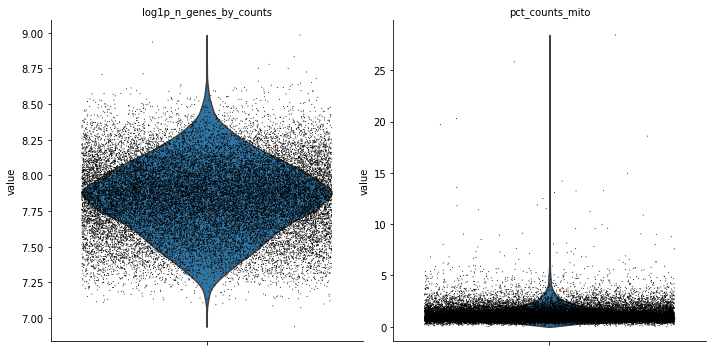

In [56]:
# step2. plotting the qc metrics
sc.pl.violin(adata_DA, ['log1p_n_genes_by_counts',  'pct_counts_mito'],
            jitter=0.4, multi_panel=True)

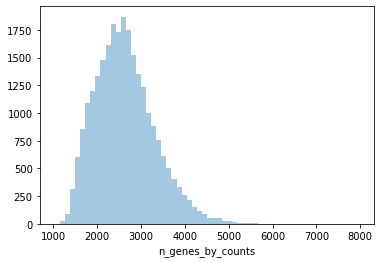

In [57]:
#step 3.we come up with thresholding decsions for genes for the FPP cells

p6 = sb.distplot(adata_DA.obs['n_genes_by_counts'], kde=False, bins=60)
plt.show()

In [58]:
#QC 2 - cell level - remove cells with high mito fraction

print('Number of cells before MT filter: {:d}'.format(adata_DA.n_obs))
adata_DA = adata_DA[adata_DA.obs['pct_counts_mito'] < 5]
print('Number of cells after MT filter: {:d}'.format(adata_DA.n_obs))

Number of cells before MT filter: 25470
Number of cells after MT filter: 25332


In [59]:
#QC -3 - gene level

#Filter genes that are not expressed in more than 20 cells in the DA cells
print('Total number of genes: {:d}'.format(adata_DA.n_vars))

# Min 20 cells - filters out 0 count genes

sc.pp.filter_genes(adata_DA, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata_DA.n_vars))

Total number of genes: 32738


Trying to set attribute `.var` of view, copying.


Number of genes after cell filter: 18614


In [60]:
# normalization 
# The simplest way to normalize this data is to convert it to counts per million (CPM) by dividing each row by a size factor (the sum of all counts in the row), then multiplying by 1,000,000. Note that this method assumes that each cell originally contained the same amount of RNA.
adata_DA_cpm = adata_DA.copy() # apply this to a copy so we can compare methods
adata_DA_cpm.raw = adata_DA_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_DA_cpm, 
                         counts_per_cell_after=1e6)



In [61]:
# log transformation 
sc.pp.log1p(adata_DA_cpm)
adata_DA_cpm

AnnData object with n_obs × n_vars = 25332 × 18614
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'celltype_colors', 'log1p'
    obsm: 'X_umap'

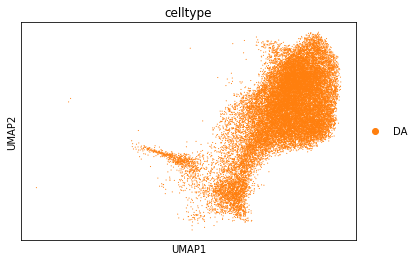

In [62]:
# plotting a umap
plotting_fcn = sc.pl.umap
plotting_fcn(adata_DA_cpm, color='celltype')

In [63]:
# aggregate the normalized and log-transformed data for per gene per individual

means = pd.DataFrame(index=adata_DA_cpm.var_names)
for k, indices in adata_DA.obs.groupby("donor_id").indices.items():
    means[k] = np.ravel(adata_DA_cpm.X[indices].mean(axis=0))
    

In [64]:
df = means
df

HPSI0114i-bezi_3  HPSI0114i-eipl_1  HPSI0114i-fikt_3  \
index                                                                 
RP11-34P13.7           0.000000          0.000000          0.000000   
AL627309.1             0.000000          0.077485          0.122481   
AP006222.2             2.450130          1.995680          1.428591   
RP4-669L17.10          0.000000          0.000000          0.000000   
RP11-206L10.3          0.000000          0.000000          0.000000   
...                         ...               ...               ...   
AC011043.1             0.635273          0.000000          0.245794   
AL592183.1             2.426593          0.000000          0.583432   
AC011841.1             0.000000          0.000000          0.000000   
PNRC2-1                0.000000          0.000000          0.000000   
SRSF10-1               0.267298          0.147931          0.230368   

               HPSI0114i-kolf_2  HPSI0114i-lexy_2  HPSI0114i-posc_1  \
index                                                                 
RP11-34P13.7           0.022585          0.000000          0.000000   
AL627309.1             0.092388          0.112169          0.000000   
AP006222.2             2.397466          1.475387          1.581944   
RP4-669L17.10          0.022066          0.000000          0.000000   
RP11-206L10.3          0.130127          0.213964          0.000000   
...                         ...               ...               ...   
AC011043.1             0.249415          0.000000          0.000000   
AL592183.1             0.305484          0.326492          2.753149   
AC011841.1             0.000000          0.000000          0.000000   
PNRC2-1                0.000000          0.000000          0.000000   
SRSF10-1               0.037630          0.320133          0.202289   

               HPSI0114i-rozh_4  HPSI0114i-vass_1  HPSI0114i-wegi_1  \
index                                                                 
RP11-34P13.7           0.000000          0.000000          0.000000   
AL627309.1             0.000000          0.000000          0.000000   
AP006222.2             1.481995          1.443123          1.319789   
RP4-669L17.10          0.000000          0.000000          0.032947   
RP11-206L10.3          0.000000          0.181317          0.134888   
...                         ...               ...               ...   
AC011043.1             0.153455          0.713656          0.136077   
AL592183.1             3.762472          1.270341          0.137581   
AC011841.1             0.000000          0.000000          0.000000   
PNRC2-1                0.000000          0.000000          0.000000   
SRSF10-1               0.157769          0.701375          0.241978   

               HPSI0114i-zapk_2  ...  HPSI1113i-hayt_3  HPSI1113i-ieki_3  \
index                            ...                                       
RP11-34P13.7           0.007731  ...          0.000000           0.00000   
AL627309.1             0.058944  ...          0.064294           0.00000   
AP006222.2             2.152012  ...          2.030107           0.00000   
RP4-669L17.10          0.032422  ...          0.000000           0.00000   
RP11-206L10.3          0.050090  ...          0.129452           0.00000   
...                         ...  ...               ...               ...   
AC011043.1             0.419989  ...          0.223036           0.00000   
AL592183.1             1.256430  ...          2.036240           0.82359   
AC011841.1             0.007771  ...          0.032502           0.00000   
PNRC2-1                0.008215  ...          0.031057           0.00000   
SRSF10-1               0.267726  ...          0.028754           0.00000   

               HPSI1113i-podx_1  HPSI1113i-qolg_1  HPSI1113i-qorq_1  \
index                                                                 
RP11-34P13.7           0.000000          0.000000          0.000000   
AL627309.1             0.000000          

In [65]:
df.to_csv("DA_ROT.csv")

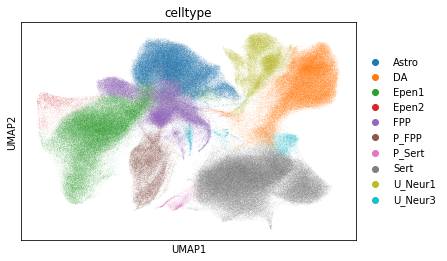

In [31]:
# now let's do the same for the other cell type - PFPP
# since this data has been already clustered and annotated- let's plot the umap plot 
plotting_fcn = sc.pl.umap
plotting_fcn(adata, color='celltype')

In [33]:
#let's subset a specific celltype 
#subsample celltype
selected_celltype = ['Epen1']
adata_Epen = adata[adata.obs['celltype'].isin(selected_celltype),: ]
adata_Epen

View of AnnData object with n_obs × n_vars = 92147 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    uns: 'celltype_colors'
    obsm: 'X_umap'

In [6]:
selected_tr = ['ROT']
adata_Epen = adata_Epen[adata_Epen.obs['treatment'].isin(selected_tr),: ]
adata_Epen

View of AnnData object with n_obs × n_vars = 42063 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    obsm: 'X_umap'

In [7]:
# step1.calclate qc metrics 
adata_Epen.var['mito'] = [x.startswith('MT-') for x in adata.var.index] 
sc.pp.calculate_qc_metrics(adata_Epen, inplace=True, qc_vars=['mito'])

Trying to set attribute `.var` of view, copying.


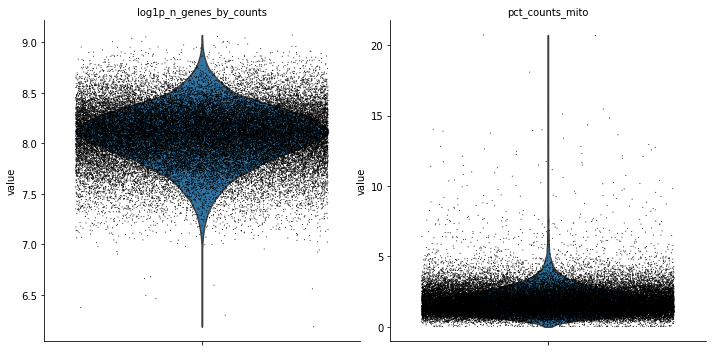

In [8]:
# step2. plotting the qc metrics
sc.pl.violin(adata_Epen, ['log1p_n_genes_by_counts',  'pct_counts_mito'],
            jitter=0.4, multi_panel=True)

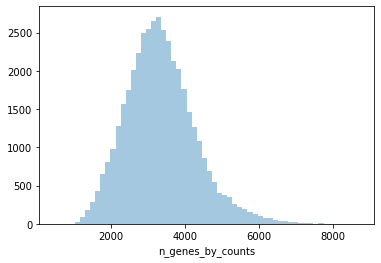

In [9]:
#step 3.we come up with thresholding decsions for genes for the FPP cells

p6 = sb.distplot(adata_Epen.obs['n_genes_by_counts'], kde=False, bins=60)
plt.show()

In [10]:
#QC -3 - gene level

#Filter genes that are not expressed in more than 20 cells in the FPP cells
print('Total number of genes: {:d}'.format(adata_Epen.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_Epen, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata_Epen.n_vars))

Total number of genes: 32738
Number of genes after cell filter: 20517


In [11]:
# normalization 
# The simplest way to normalize this data is to convert it to counts per million (CPM) by dividing each row by a size factor (the sum of all counts in the row), then multiplying by 1,000,000. Note that this method assumes that each cell originally contained the same amount of RNA.
adata_Epen_cpm = adata_Epen.copy() # apply this to a copy so we can compare methods
adata_Epen_cpm.raw = adata_Epen_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_Epen_cpm, 
                         counts_per_cell_after=1e6)

In [12]:
# log transformation 
sc.pp.log1p(adata_Epen_cpm)
adata_Epen_cpm

AnnData object with n_obs × n_vars = 42063 × 20517
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p'
    obsm: 'X_umap'

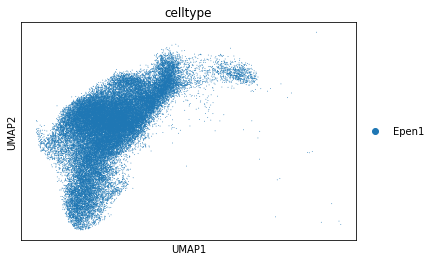

In [13]:
# plotting a umap
plotting_fcn = sc.pl.umap
plotting_fcn(adata_Epen_cpm, color='celltype')

In [14]:
# aggregate the normalized and log-transformed data for per gene per individual

means = pd.DataFrame(index=adata_Epen_cpm.var_names)
for k, indices in adata_Epen.obs.groupby("donor_id").indices.items():
    means[k] = np.ravel(adata_Epen_cpm.X[indices].mean(axis=0))
  

In [15]:
df = means
df

HPSI0114i-bezi_3  HPSI0114i-eipl_1  HPSI0114i-fikt_3  \
index                                                                 
RP11-34P13.7           0.000000          0.000000          0.000000   
AL627309.1             0.094187          0.083579          0.000000   
AP006222.2             2.543938          2.131168          1.221052   
RP4-669L17.10          0.000000          0.008882          0.000000   
RP4-669L17.2           0.000000          0.000000          0.000000   
...                         ...               ...               ...   
AL592183.1             1.262786          0.015639          0.552146   
AC011841.1             0.000000          0.008656          0.000000   
AL354822.1             0.000000          0.000000          0.000000   
PNRC2-1                0.107533          0.028456          0.000000   
SRSF10-1               0.203931          0.440726          0.406495   

               HPSI0114i-kolf_2  HPSI0114i-lexy_2  HPSI0114i-posc_1  \
index                                                                 
RP11-34P13.7           0.000000          0.000000          0.000000   
AL627309.1             0.097017          0.000000          0.000000   
AP006222.2             3.521088          1.892073          1.676803   
RP4-669L17.10          0.000000          0.000000          0.000000   
RP4-669L17.2           0.000000          0.000000          0.000000   
...                         ...               ...               ...   
AL592183.1             0.077684          0.156363          1.101059   
AC011841.1             0.000000          0.000000          0.000000   
AL354822.1             0.000000          0.000000          0.000000   
PNRC2-1                0.000000          0.000000          0.496087   
SRSF10-1               0.031956          0.141153          1.004092   

               HPSI0114i-rozh_4  HPSI0114i-vass_1  HPSI0114i-wegi_1  \
index                                                                 
RP11-34P13.7           0.000000          0.000000          0.000000   
AL627309.1             0.133562          0.000000          0.616337   
AP006222.2             2.766273          3.151178          1.699961   
RP4-669L17.10          0.000000          0.000000          0.000000   
RP4-669L17.2           0.000000          0.000000          0.000000   
...                         ...               ...               ...   
AL592183.1             0.987491          1.137339          0.549672   
AC011841.1             0.131400          0.000000          0.000000   
AL354822.1             0.000000          0.000000          0.000000   
PNRC2-1                0.120533          0.000000          0.000000   
SRSF10-1               0.413368          1.017233          0.000000   

               HPSI0114i-zapk_2  ...  HPSI1113i-ieki_3  HPSI1113i-podx_1  \
index                            ...                                       
RP11-34P13.7           0.000000  ...          0.000000          0.000000   
AL627309.1             0.000000  ...          0.091517          0.075138   
AP006222.2             2.386624  ...          3.321191          2.792146   
RP4-669L17.10          0.000000  ...          0.000000          0.014298   
RP4-669L17.2           0.000000  ...          0.000000          0.000000   
...                         ...  ...               ...               ...   
AL592183.1             0.555412  ...          0.505888          0.433889   
AC011841.1             0.000000  ...          0.000000          0.000000   
AL354822.1             0.000000  ...          0.000000          0.000000   
PNRC2-1                0.000000  ...          0.000000          0.014914   
SRSF10-1               0.502276  ...          0.439758          0.495712   

               HPSI1113i-qolg_1  HPSI1113i-qorq_1  HPSI1113i-vuud_2  \
index                                                                 
RP11-34P13.7           0.000000          0.000000          0.012599   
AL627309.1             0.115489          

In [16]:
df.to_csv("Epen_ROT.csv")

In [18]:
selected_tr = ['NONE']
adata_Epen = adata_Epen[adata_Epen.obs['treatment'].isin(selected_tr),: ]
adata_Epen

View of AnnData object with n_obs × n_vars = 50084 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    obsm: 'X_umap'

In [19]:
# step1.calclate qc metrics 
adata_Epen.var['mito'] = [x.startswith('MT-') for x in adata.var.index] 
sc.pp.calculate_qc_metrics(adata_Epen, inplace=True, qc_vars=['mito'])

Trying to set attribute `.var` of view, copying.


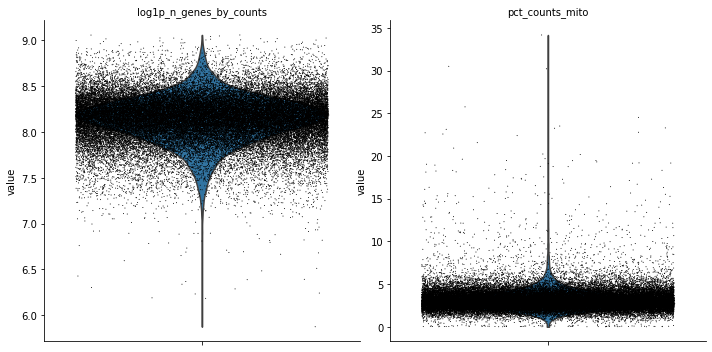

In [20]:
# step2. plotting the qc metrics
sc.pl.violin(adata_Epen, ['log1p_n_genes_by_counts',  'pct_counts_mito'],
            jitter=0.4, multi_panel=True)

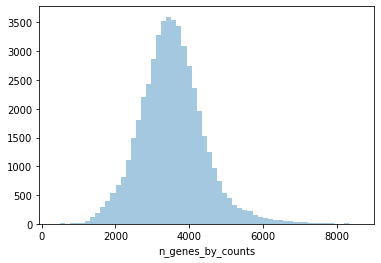

In [21]:
#step 3.we come up with thresholding decsions for genes for the FPP cells

p6 = sb.distplot(adata_Epen.obs['n_genes_by_counts'], kde=False, bins=60)
plt.show()

In [22]:
#QC 2 - cell level - remove cells with high mito fraction

print('Number of cells before MT filter: {:d}'.format(adata_Epen.n_obs))
adata_Epen = adata_Epen[adata_Epen.obs['pct_counts_mito'] < 5]
print('Number of cells after MT filter: {:d}'.format(adata_Epen.n_obs))

Number of cells before MT filter: 50084
Number of cells after MT filter: 47486


In [23]:
#QC -3 - gene level

#Filter genes that are not expressed in more than 20 cells in the FPP cells
print('Total number of genes: {:d}'.format(adata_Epen.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_Epen, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata_Epen.n_vars))

Total number of genes: 32738


Trying to set attribute `.var` of view, copying.


Number of genes after cell filter: 21056


In [24]:
# normalization 
# The simplest way to normalize this data is to convert it to counts per million (CPM) by dividing each row by a size factor (the sum of all counts in the row), then multiplying by 1,000,000. Note that this method assumes that each cell originally contained the same amount of RNA.
adata_Epen_cpm = adata_Epen.copy() # apply this to a copy so we can compare methods
adata_Epen_cpm.raw = adata_Epen_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_Epen_cpm, 
                         counts_per_cell_after=1e6)

In [25]:
# log transformation 
sc.pp.log1p(adata_Epen_cpm)
adata_Epen_cpm

AnnData object with n_obs × n_vars = 47486 × 21056
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p'
    obsm: 'X_umap'

In [26]:
# aggregate the normalized and log-transformed data for per gene per individual

means = pd.DataFrame(index=adata_Epen_cpm.var_names)
for k, indices in adata_Epen.obs.groupby("donor_id").indices.items():
    means[k] = np.ravel(adata_Epen_cpm.X[indices].mean(axis=0))
 

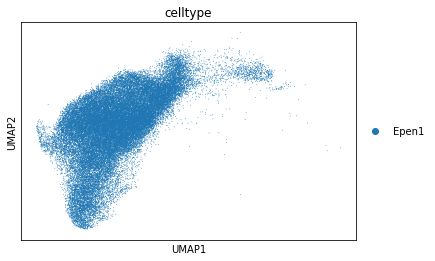

In [27]:
# plotting a umap
plotting_fcn = sc.pl.umap
plotting_fcn(adata_Epen_cpm, color='celltype')

In [28]:
df = means
df

HPSI0114i-bezi_3  HPSI0114i-eipl_1  HPSI0114i-fikt_3  \
index                                                                 
RP11-34P13.7           0.000000          0.002850          0.000000   
AL627309.1             0.000000          0.113306          0.122036   
AP006222.2             2.115309          1.979068          1.206381   
RP4-669L17.10          0.000000          0.011676          0.000000   
RP11-206L10.3          0.000000          0.076420          0.000000   
...                         ...               ...               ...   
AL592183.1             1.046431          0.014422          0.406698   
AC011841.1             0.000000          0.031835          0.000000   
AL354822.1             0.000000          0.000000          0.000000   
PNRC2-1                0.110605          0.039001          0.000000   
SRSF10-1               1.183108          0.715300          0.918046   

               HPSI0114i-kolf_2  HPSI0114i-lexy_2  HPSI0114i-posc_1  \
index                                                                 
RP11-34P13.7           0.000000          0.000000          0.000000   
AL627309.1             0.086065          0.000000          0.000000   
AP006222.2             2.055260          1.671532          1.684248   
RP4-669L17.10          0.000000          0.000000          0.000000   
RP11-206L10.3          0.029070          0.000000          0.000000   
...                         ...               ...               ...   
AL592183.1             0.062068          0.000000          2.119316   
AC011841.1             0.000000          0.000000          0.000000   
AL354822.1             0.000000          0.000000          0.000000   
PNRC2-1                0.031881          0.000000          0.405099   
SRSF10-1               0.025983          0.581774          0.751901   

               HPSI0114i-rozh_4  HPSI0114i-vass_1  HPSI0114i-wegi_1  \
index                                                                 
RP11-34P13.7           0.000000          0.000000          0.000000   
AL627309.1             0.273571          1.032481          0.275034   
AP006222.2             2.694117          1.046816          1.668247   
RP4-669L17.10          0.000000          0.000000          0.000000   
RP11-206L10.3          0.000000          0.000000          0.256352   
...                         ...               ...               ...   
AL592183.1             0.988199          1.046816          0.000000   
AC011841.1             0.000000          0.000000          0.275034   
AL354822.1             0.000000          0.000000          0.000000   
PNRC2-1                0.230429          0.000000          0.000000   
SRSF10-1               0.259895          0.960209          0.269909   

               HPSI0114i-zapk_2  ...  HPSI1113i-ieki_3  HPSI1113i-podx_1  \
index                            ...                                       
RP11-34P13.7           0.000000  ...          0.000000          0.015413   
AL627309.1             0.180901  ...          0.000000          0.150994   
AP006222.2             2.571485  ...          2.755427          2.408192   
RP4-669L17.10          0.000000  ...          0.000000          0.081853   
RP11-206L10.3          0.000000  ...          0.158157          0.134574   
...                         ...  ...               ...               ...   
AL592183.1             0.155471  ...          0.785179          0.499975   
AC011841.1             0.000000  ...          0.000000          0.000000   
AL354822.1             0.000000  ...          0.000000          0.000000   
PNRC2-1                0.000000  ...          0.000000          0.067875   
SRSF10-1               0.495140  ...          0.479073          0.569686   

               HPSI1113i-qolg_1  HPSI1113i-qorq_1  HPSI1113i-vuud_2  \
index                                                                 
RP11-34P13.7           0.000000          0.000000          0.000000   
AL627309.1             0.082909          

In [29]:
df.to_csv("Epen_NONE.csv")

In [49]:
#let's subset a specific celltype 
#subsample celltype
selected_celltype = ['FPP']
adata_FPP = adata[adata.obs['celltype'].isin(selected_celltype),: ]
adata_FPP

View of AnnData object with n_obs × n_vars = 65718 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    uns: 'celltype_colors'
    obsm: 'X_umap'

In [50]:
selected_tr = ['ROT']
adata_FPP = adata_FPP[adata_FPP.obs['treatment'].isin(selected_tr),: ]
adata_FPP

View of AnnData object with n_obs × n_vars = 31203 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    uns: 'celltype_colors'
    obsm: 'X_umap'

In [51]:
# step1.calclate qc metrics 
adata_FPP.var['mito'] = [x.startswith('MT-') for x in adata.var.index] 
sc.pp.calculate_qc_metrics(adata_FPP, inplace=True, qc_vars=['mito'])

Trying to set attribute `.var` of view, copying.


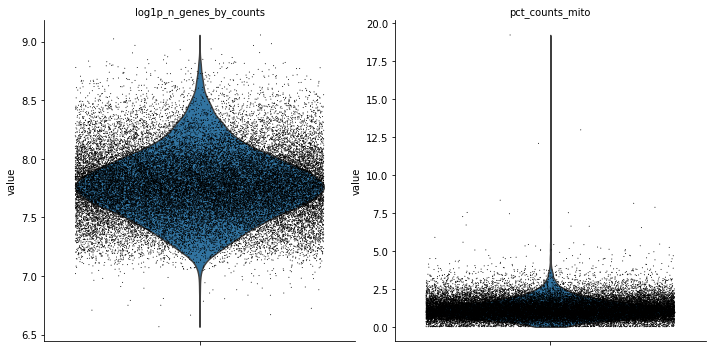

In [52]:
# step2. plotting the qc metrics
sc.pl.violin(adata_FPP, ['log1p_n_genes_by_counts',  'pct_counts_mito'],
            jitter=0.4, multi_panel=True)

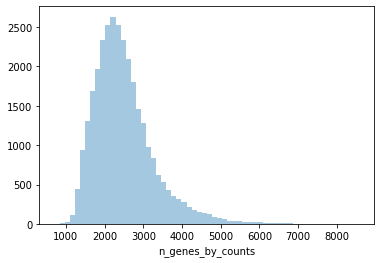

In [53]:
#step 3.we come up with thresholding decsions for genes for the FPP cells

p6 = sb.distplot(adata_FPP.obs['n_genes_by_counts'], kde=False, bins=60)
plt.show()

In [54]:
#QC 2 - cell level - remove cells with high mito fraction

print('Number of cells before MT filter: {:d}'.format(adata_FPP.n_obs))
adata_FPP = adata_FPP[adata_FPP.obs['pct_counts_mito'] < 5]
print('Number of cells after MT filter: {:d}'.format(adata_FPP.n_obs))

Number of cells before MT filter: 31203
Number of cells after MT filter: 31168


In [55]:
#QC -3 - gene level

#Filter genes that are not expressed in more than 20 cells in the FPP cells
print('Total number of genes: {:d}'.format(adata_FPP.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_FPP, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata_FPP.n_vars))

Total number of genes: 32738


Trying to set attribute `.var` of view, copying.


Number of genes after cell filter: 19243


In [56]:
# normalization 
# The simplest way to normalize this data is to convert it to counts per million (CPM) by dividing each row by a size factor (the sum of all counts in the row), then multiplying by 1,000,000. Note that this method assumes that each cell originally contained the same amount of RNA.
adata_FPP_cpm = adata_FPP.copy() # apply this to a copy so we can compare methods
adata_FPP_cpm.raw = adata_FPP_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_FPP_cpm, 
                         counts_per_cell_after=1e6)

In [57]:
# log transformation 
sc.pp.log1p(adata_FPP_cpm)
adata_FPP_cpm

AnnData object with n_obs × n_vars = 31168 × 19243
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'celltype_colors', 'log1p'
    obsm: 'X_umap'

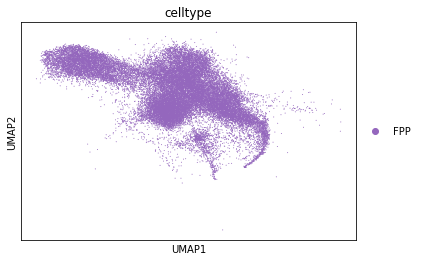

In [58]:
# plotting a umap
plotting_fcn = sc.pl.umap
plotting_fcn(adata_FPP_cpm, color='celltype')

In [59]:
# aggregate the normalized and log-transformed data for per gene per individual

means = pd.DataFrame(index=adata_FPP_cpm.var_names)
for k, indices in adata_FPP.obs.groupby("donor_id").indices.items():
    means[k] = np.ravel(adata_FPP_cpm.X[indices].mean(axis=0))
 

In [60]:
df = means


In [61]:
df.to_csv("FPP_ROT.csv")

In [5]:
#let's subset a specific celltype 
#subsample celltype
selected_celltype = ['P_FPP']
adata_PFPP = adata[adata.obs['celltype'].isin(selected_celltype),: ]
adata_PFPP

View of AnnData object with n_obs × n_vars = 25131 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    obsm: 'X_umap'

In [6]:
selected_tr = ['NONE']
adata_PFPP = adata_PFPP[adata_PFPP.obs['treatment'].isin(selected_tr),: ]
adata_PFPP

View of AnnData object with n_obs × n_vars = 15390 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    obsm: 'X_umap'

In [7]:
# step1.calclate qc metrics 
adata_PFPP.var['mito'] = [x.startswith('MT-') for x in adata.var.index] 
sc.pp.calculate_qc_metrics(adata_PFPP, inplace=True, qc_vars=['mito'])

Trying to set attribute `.var` of view, copying.


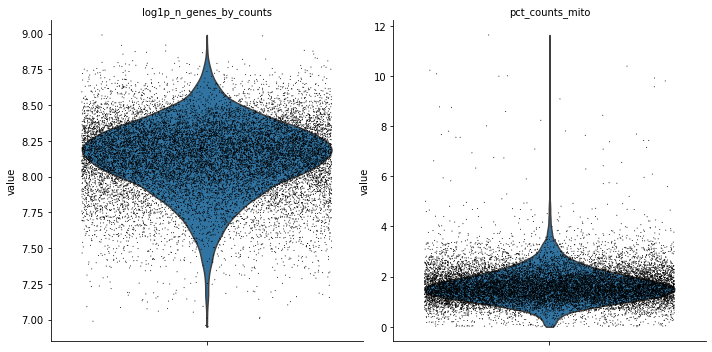

In [8]:
# step2. plotting the qc metrics
sc.pl.violin(adata_PFPP, ['log1p_n_genes_by_counts',  'pct_counts_mito'],
            jitter=0.4, multi_panel=True)

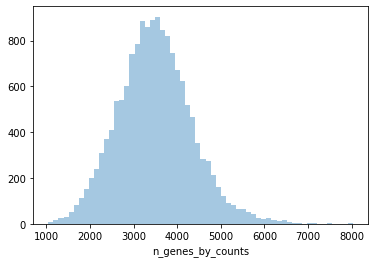

In [9]:
#step 3.we come up with thresholding decsions for genes for the FPP cells

p6 = sb.distplot(adata_PFPP.obs['n_genes_by_counts'], kde=False, bins=60)
plt.show()



In [10]:
#QC 2 - cell level - remove cells with high mito fraction

print('Number of cells before MT filter: {:d}'.format(adata_PFPP.n_obs))
adata_PFPP = adata_PFPP[adata_PFPP.obs['pct_counts_mito'] < 5]
print('Number of cells after MT filter: {:d}'.format(adata_PFPP.n_obs))

Number of cells before MT filter: 15390
Number of cells after MT filter: 15340


In [11]:
#QC -3 - gene level

#Filter genes that are not expressed in more than 20 cells in the FPP cells
print('Total number of genes: {:d}'.format(adata_PFPP.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_PFPP, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata_PFPP.n_vars))

Total number of genes: 32738


Trying to set attribute `.var` of view, copying.


Number of genes after cell filter: 18341


In [12]:
# normalization 
# The simplest way to normalize this data is to convert it to counts per million (CPM) by dividing each row by a size factor (the sum of all counts in the row), then multiplying by 1,000,000. Note that this method assumes that each cell originally contained the same amount of RNA.
adata_PFPP_cpm = adata_PFPP.copy() # apply this to a copy so we can compare methods
adata_PFPP_cpm.raw = adata_PFPP_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_PFPP_cpm, 
                         counts_per_cell_after=1e6)

In [13]:
# log transformation 
sc.pp.log1p(adata_PFPP_cpm)
adata_PFPP_cpm

AnnData object with n_obs × n_vars = 15340 × 18341
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p'
    obsm: 'X_umap'

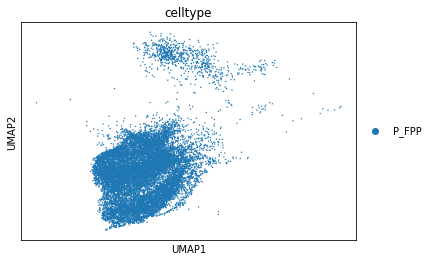

In [14]:
# plotting a umap
plotting_fcn = sc.pl.umap
plotting_fcn(adata_PFPP_cpm, color='celltype')

In [15]:
# aggregate the normalized and log-transformed data for per gene per individual

means = pd.DataFrame(index=adata_PFPP_cpm.var_names)
for k, indices in adata_PFPP.obs.groupby("donor_id").indices.items():
    means[k] = np.ravel(adata_PFPP_cpm.X[indices].mean(axis=0))

In [16]:
df = means

In [17]:
df.to_csv("PFPP_NONE.csv")

In [91]:
#let's subset a specific celltype 
#subsample celltype
selected_celltype = ['P_Sert']
adata_Sert = adata[adata.obs['celltype'].isin(selected_celltype),: ]
adata_Sert

View of AnnData object with n_obs × n_vars = 2573 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    uns: 'celltype_colors'
    obsm: 'X_umap'

In [79]:
selected_tr = ['ROT']
adata_Sert = adata_Sert[adata_Sert.obs['treatment'].isin(selected_tr),: ]
adata_Sert

View of AnnData object with n_obs × n_vars = 780 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    uns: 'celltype_colors'
    obsm: 'X_umap'

In [80]:
# step1.calclate qc metrics 
adata_Sert.var['mito'] = [x.startswith('MT-') for x in adata.var.index] 
sc.pp.calculate_qc_metrics(adata_Sert, inplace=True, qc_vars=['mito'])

Trying to set attribute `.var` of view, copying.


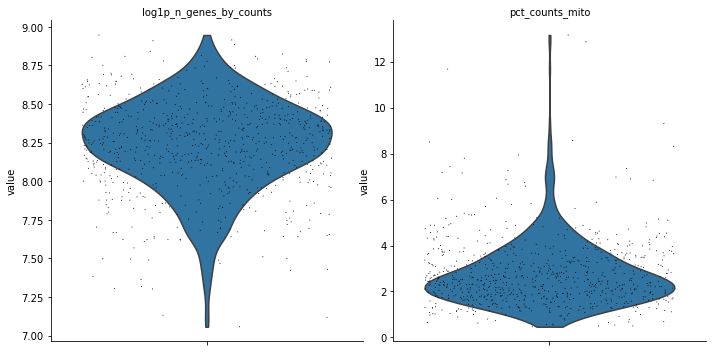

In [81]:
# step2. plotting the qc metrics
sc.pl.violin(adata_Sert, ['log1p_n_genes_by_counts',  'pct_counts_mito'],
            jitter=0.4, multi_panel=True)

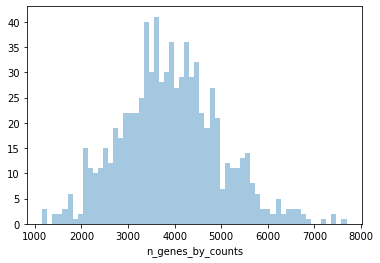

In [82]:
#step 3.we come up with thresholding decsions for genes for the FPP cells

p6 = sb.distplot(adata_Sert.obs['n_genes_by_counts'], kde=False, bins=60)
plt.show()

In [83]:
#QC 2 - cell level - remove cells with high mito fraction

print('Number of cells before MT filter: {:d}'.format(adata_Sert.n_obs))
adata_Sert = adata_Sert[adata_Sert.obs['pct_counts_mito'] < 5]
print('Number of cells after MT filter: {:d}'.format(adata_Sert.n_obs))

Number of cells before MT filter: 780
Number of cells after MT filter: 740


In [84]:
#QC -3 - gene level

#Filter genes that are not expressed in more than 20 cells in the NB cells
print('Total number of genes: {:d}'.format(adata_Sert.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_Sert, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata_Sert.n_vars))

Trying to set attribute `.var` of view, copying.


Total number of genes: 32738
Number of genes after cell filter: 12600


In [85]:
# normalization 
# The simplest way to normalize this data is to convert it to counts per million (CPM) by dividing each row by a size factor (the sum of all counts in the row), then multiplying by 1,000,000. Note that this method assumes that each cell originally contained the same amount of RNA.
adata_Sert_cpm = adata_Sert.copy() # apply this to a copy so we can compare methods
adata_Sert_cpm.raw = adata_Sert_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_Sert_cpm, 
                         counts_per_cell_after=1e6)

In [86]:
# log transformation 
sc.pp.log1p(adata_Sert_cpm)
adata_Sert_cpm

AnnData object with n_obs × n_vars = 740 × 12600
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'celltype_colors', 'log1p'
    obsm: 'X_umap'

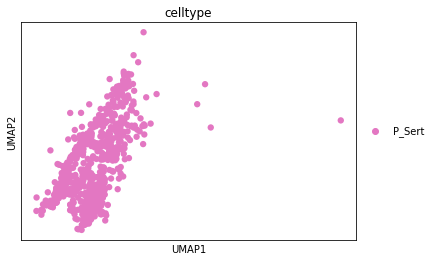

In [87]:
# plotting a umap
plotting_fcn = sc.pl.umap
plotting_fcn(adata_Sert_cpm, color='celltype')

In [88]:
# aggregate the normalized and log-transformed data for per gene per individual

means = pd.DataFrame(index=adata_Sert_cpm.var_names)
for k, indices in adata_Sert.obs.groupby("donor_id").indices.items():
    means[k] = np.ravel(adata_Sert_cpm.X[indices].mean(axis=0))
    

In [89]:
df = means

In [90]:
df.to_csv("Sert_ROT.csv")

In [92]:
selected_tr = ['NONE']
adata_Sert = adata_Sert[adata_Sert.obs['treatment'].isin(selected_tr),: ]
adata_Sert

View of AnnData object with n_obs × n_vars = 1793 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    uns: 'celltype_colors'
    obsm: 'X_umap'

In [93]:
# step1.calclate qc metrics 
adata_Sert.var['mito'] = [x.startswith('MT-') for x in adata.var.index] 
sc.pp.calculate_qc_metrics(adata_Sert, inplace=True, qc_vars=['mito'])

Trying to set attribute `.var` of view, copying.


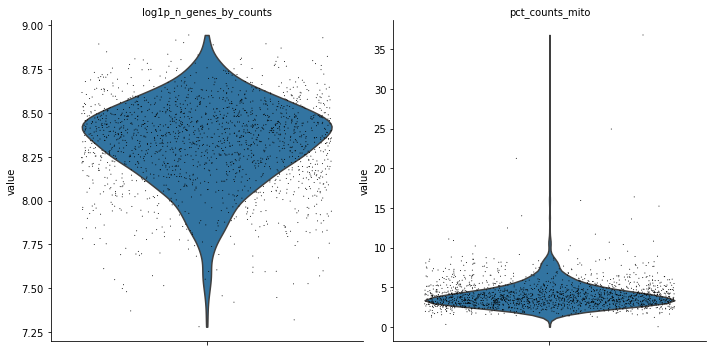

In [94]:
# step2. plotting the qc metrics
sc.pl.violin(adata_Sert, ['log1p_n_genes_by_counts',  'pct_counts_mito'],
            jitter=0.4, multi_panel=True)

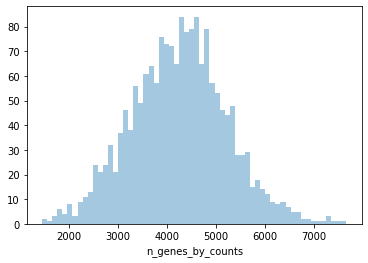

In [95]:
#step 3.we come up with thresholding decsions for genes for the FPP cells

p6 = sb.distplot(adata_Sert.obs['n_genes_by_counts'], kde=False, bins=60)
plt.show()

In [96]:
#QC 2 - cell level - remove cells with high mito fraction

print('Number of cells before MT filter: {:d}'.format(adata_Sert.n_obs))
adata_Sert = adata_Sert[adata_Sert.obs['pct_counts_mito'] < 5]
print('Number of cells after MT filter: {:d}'.format(adata_Sert.n_obs))

Number of cells before MT filter: 1793
Number of cells after MT filter: 1435


In [97]:
# normalization 
# The simplest way to normalize this data is to convert it to counts per million (CPM) by dividing each row by a size factor (the sum of all counts in the row), then multiplying by 1,000,000. Note that this method assumes that each cell originally contained the same amount of RNA.
adata_Sert_cpm = adata_Sert.copy() # apply this to a copy so we can compare methods
adata_Sert_cpm.raw = adata_Sert_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_Sert_cpm, 
                         counts_per_cell_after=1e6)

In [98]:
# log transformation 
sc.pp.log1p(adata_Sert_cpm)
adata_Sert_cpm

AnnData object with n_obs × n_vars = 1435 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'celltype_colors', 'log1p'
    obsm: 'X_umap'

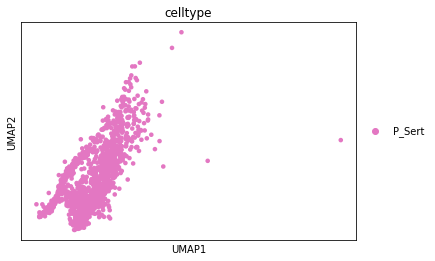

In [99]:
# plotting a umap
plotting_fcn = sc.pl.umap
plotting_fcn(adata_Sert_cpm, color='celltype')

In [100]:
# aggregate the normalized and log-transformed data for per gene per individual

means = pd.DataFrame(index=adata_Sert_cpm.var_names)
for k, indices in adata_Sert.obs.groupby("donor_id").indices.items():
    means[k] = np.ravel(adata_Sert_cpm.X[indices].mean(axis=0))
 

In [101]:
df = means

In [102]:
df.to_csv("PSert_NONE.csv")

In [7]:
#let's subset a specific celltype 
#subsample celltype
selected_celltype = ['Sert']
adata_Sert = adata[adata.obs['celltype'].isin(selected_celltype),: ]
adata_Sert

View of AnnData object with n_obs × n_vars = 130209 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    obsm: 'X_umap'

In [8]:
selected_tr = ['NONE']
adata_Sert = adata_Sert[adata_Sert.obs['treatment'].isin(selected_tr),: ]
adata_Sert

View of AnnData object with n_obs × n_vars = 74984 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    obsm: 'X_umap'

In [9]:
# step1.calclate qc metrics 
adata_Sert.var['mito'] = [x.startswith('MT-') for x in adata.var.index] 
sc.pp.calculate_qc_metrics(adata_Sert, inplace=True, qc_vars=['mito'])

Trying to set attribute `.var` of view, copying.


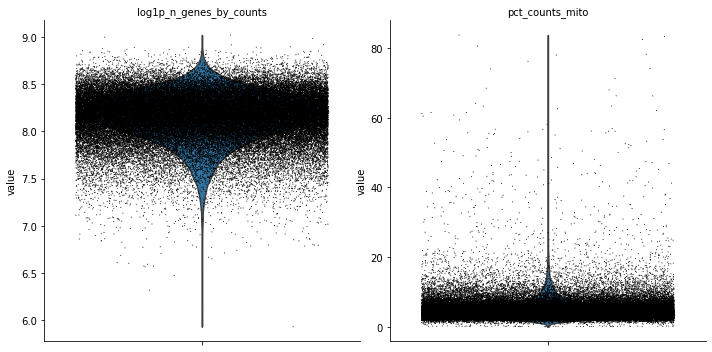

In [10]:
# step2. plotting the qc metrics
sc.pl.violin(adata_Sert, ['log1p_n_genes_by_counts',  'pct_counts_mito'],
            jitter=0.4, multi_panel=True)

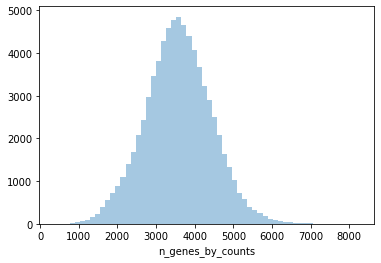

In [11]:
#step 3.we come up with thresholding decsions for genes for the FPP cells

p6 = sb.distplot(adata_Sert.obs['n_genes_by_counts'], kde=False, bins=60)
plt.show()

In [12]:
#QC 2 - cell level - remove cells with high mito fraction

print('Number of cells before MT filter: {:d}'.format(adata_Sert.n_obs))
adata_Sert = adata_Sert[adata_Sert.obs['pct_counts_mito'] < 5]
print('Number of cells after MT filter: {:d}'.format(adata_Sert.n_obs))

Number of cells before MT filter: 74984
Number of cells after MT filter: 48319


In [13]:
#QC -3 - gene level

#Filter genes that are not expressed in more than 20 cells in the NB cells
print('Total number of genes: {:d}'.format(adata_Sert.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_Sert, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata_Sert.n_vars))

Total number of genes: 32738


Trying to set attribute `.var` of view, copying.


Number of genes after cell filter: 20582


In [14]:
# normalization 
# The simplest way to normalize this data is to convert it to counts per million (CPM) by dividing each row by a size factor (the sum of all counts in the row), then multiplying by 1,000,000. Note that this method assumes that each cell originally contained the same amount of RNA.
adata_Sert_cpm = adata_Sert.copy() # apply this to a copy so we can compare methods
adata_Sert_cpm.raw = adata_Sert_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_Sert_cpm, 
                         counts_per_cell_after=1e6)

In [15]:
# log transformation 
sc.pp.log1p(adata_Sert_cpm)
adata_Sert_cpm

AnnData object with n_obs × n_vars = 48319 × 20582
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p'
    obsm: 'X_umap'

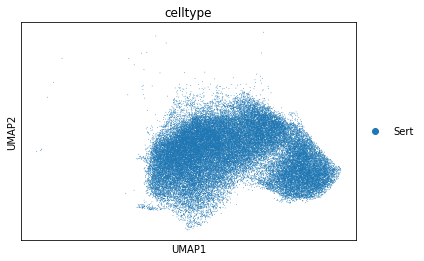

In [14]:
# plotting a umap
plotting_fcn = sc.pl.umap
plotting_fcn(adata_Sert_cpm, color='celltype')

In [16]:
# aggregate the normalized and log-transformed data for per gene per individual

means = pd.DataFrame(index=adata_Sert_cpm.var_names)
for k, indices in adata_Sert.obs.groupby("donor_id").indices.items():
    means[k] = np.ravel(adata_Sert_cpm.X[indices].mean(axis=0))
    

In [17]:
df = means

In [18]:
df.to_csv("Sert_None.csv")

In [18]:
#let's subset a specific celltype 
#subsample celltype
selected_celltype = ['Sert']
adata_Sert = adata[adata.obs['celltype'].isin(selected_celltype),: ]
adata_Sert

View of AnnData object with n_obs × n_vars = 130209 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    obsm: 'X_umap'

In [19]:
selected_tr = ['ROT']
adata_Sert = adata_Sert[adata_Sert.obs['treatment'].isin(selected_tr),: ]
adata_Sert

View of AnnData object with n_obs × n_vars = 55225 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    obsm: 'X_umap'

In [20]:
# step1.calclate qc metrics 
adata_Sert.var['mito'] = [x.startswith('MT-') for x in adata.var.index] 
sc.pp.calculate_qc_metrics(adata_Sert, inplace=True, qc_vars=['mito'])

Trying to set attribute `.var` of view, copying.


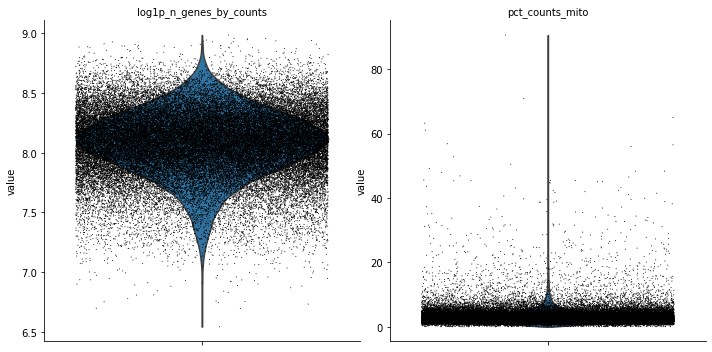

In [21]:
# step2. plotting the qc metrics
sc.pl.violin(adata_Sert, ['log1p_n_genes_by_counts',  'pct_counts_mito'],
            jitter=0.4, multi_panel=True)

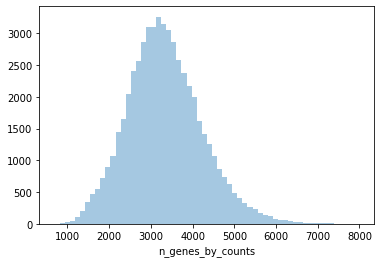

In [22]:
#step 3.we come up with thresholding decsions for genes for the FPP cells

p6 = sb.distplot(adata_Sert.obs['n_genes_by_counts'], kde=False, bins=60)
plt.show()

In [23]:
#QC 2 - cell level - remove cells with high mito fraction

print('Number of cells before MT filter: {:d}'.format(adata_Sert.n_obs))
adata_Sert = adata_Sert[adata_Sert.obs['pct_counts_mito'] < 5]
print('Number of cells after MT filter: {:d}'.format(adata_Sert.n_obs))

Number of cells before MT filter: 55225
Number of cells after MT filter: 49105


In [24]:
#QC -3 - gene level

#Filter genes that are not expressed in more than 20 cells in the NB cells
print('Total number of genes: {:d}'.format(adata_Sert.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_Sert, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata_Sert.n_vars))

Total number of genes: 32738


Trying to set attribute `.var` of view, copying.


Number of genes after cell filter: 20330


In [25]:
# normalization 
# The simplest way to normalize this data is to convert it to counts per million (CPM) by dividing each row by a size factor (the sum of all counts in the row), then multiplying by 1,000,000. Note that this method assumes that each cell originally contained the same amount of RNA.
adata_Sert_cpm = adata_Sert.copy() # apply this to a copy so we can compare methods
adata_Sert_cpm.raw = adata_Sert_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_Sert_cpm, 
                         counts_per_cell_after=1e6)

In [26]:
# log transformation 
sc.pp.log1p(adata_Sert_cpm)
adata_Sert_cpm

AnnData object with n_obs × n_vars = 49105 × 20330
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p'
    obsm: 'X_umap'

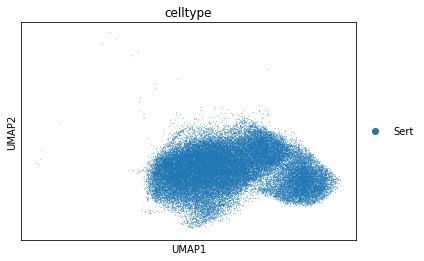

In [27]:
# plotting a umap
plotting_fcn = sc.pl.umap
plotting_fcn(adata_Sert_cpm, color='celltype')

In [28]:
# aggregate the normalized and log-transformed data for per gene per individual

means = pd.DataFrame(index=adata_Sert_cpm.var_names)
for k, indices in adata_Sert.obs.groupby("donor_id").indices.items():
    means[k] = np.ravel(adata_Sert_cpm.X[indices].mean(axis=0))
 

In [29]:
df = means

In [30]:
df.to_csv("Sert_ROT.csv")

In [46]:
#let's subset a specific celltype 
#subsample celltype
selected_celltype = ['U_Neur1']
adata_Neur1 = adata[adata.obs['celltype'].isin(selected_celltype),: ]
adata_Neur1

View of AnnData object with n_obs × n_vars = 31368 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    obsm: 'X_umap'

In [33]:
selected_tr = ['ROT']
adata_Neur1 = adata_Neur1[adata_Neur1.obs['treatment'].isin(selected_tr),: ]
adata_Neur1

View of AnnData object with n_obs × n_vars = 8694 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    obsm: 'X_umap'

In [35]:
# step1.calclate qc metrics 
adata_Neur1.var['mito'] = [x.startswith('MT-') for x in adata.var.index] 
sc.pp.calculate_qc_metrics(adata_Neur1, inplace=True, qc_vars=['mito'])

Trying to set attribute `.var` of view, copying.


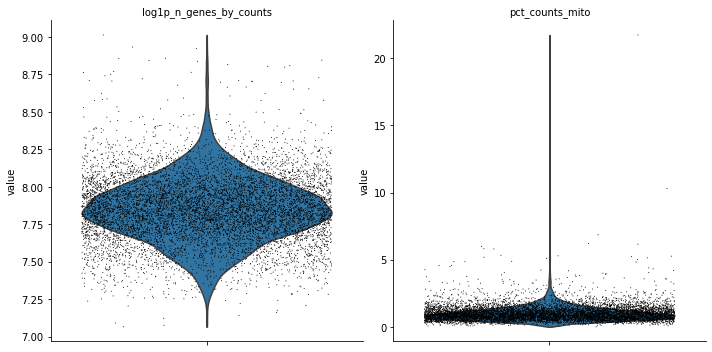

In [36]:
# step2. plotting the qc metrics
sc.pl.violin(adata_Neur1, ['log1p_n_genes_by_counts',  'pct_counts_mito'],
            jitter=0.4, multi_panel=True)

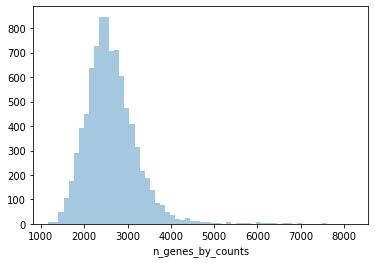

In [37]:
#step 3.we come up with thresholding decsions for genes for the FPP cells

p6 = sb.distplot(adata_Neur1.obs['n_genes_by_counts'], kde=False, bins=60)
plt.show()

In [38]:
#QC 2 - cell level - remove cells with high mito fraction

print('Number of cells before MT filter: {:d}'.format(adata_Neur1.n_obs))
adata_Neur1 = adata_Neur1[adata_Neur1.obs['pct_counts_mito'] < 5]
print('Number of cells after MT filter: {:d}'.format(adata_Neur1.n_obs))

Number of cells before MT filter: 8694
Number of cells after MT filter: 8678


In [39]:
#QC -3 - gene level

#Filter genes that are not expressed in more than 20 cells in the NB cells
print('Total number of genes: {:d}'.format(adata_Neur1.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_Neur1, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata_Neur1.n_vars))

Total number of genes: 32738


Trying to set attribute `.var` of view, copying.


Number of genes after cell filter: 16007


In [40]:
# normalization 
# The simplest way to normalize this data is to convert it to counts per million (CPM) by dividing each row by a size factor (the sum of all counts in the row), then multiplying by 1,000,000. Note that this method assumes that each cell originally contained the same amount of RNA.
adata_Neur1_cpm = adata_Neur1.copy() # apply this to a copy so we can compare methods
adata_Neur1_cpm.raw = adata_Neur1_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_Neur1_cpm, 
                         counts_per_cell_after=1e6)

In [41]:
# log transformation 
sc.pp.log1p(adata_Neur1_cpm)
adata_Neur1_cpm

AnnData object with n_obs × n_vars = 8678 × 16007
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p'
    obsm: 'X_umap'

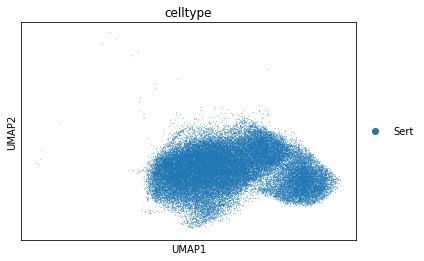

In [42]:
# plotting a umap
plotting_fcn = sc.pl.umap
plotting_fcn(adata_Sert_cpm, color='celltype')

In [43]:
# aggregate the normalized and log-transformed data for per gene per individual

means = pd.DataFrame(index=adata_Neur1_cpm.var_names)
for k, indices in adata_Neur1.obs.groupby("donor_id").indices.items():
    means[k] = np.ravel(adata_Neur1_cpm.X[indices].mean(axis=0))
    

In [44]:
df = means

In [45]:
df.to_csv("Neur1_ROT.csv")

In [48]:
selected_tr = ['NONE']
adata_Neur1 = adata_Neur1[adata_Neur1.obs['treatment'].isin(selected_tr),: ]
adata_Neur1

View of AnnData object with n_obs × n_vars = 22674 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    obsm: 'X_umap'

In [49]:
# step1.calclate qc metrics 
adata_Neur1.var['mito'] = [x.startswith('MT-') for x in adata.var.index] 
sc.pp.calculate_qc_metrics(adata_Neur1, inplace=True, qc_vars=['mito'])

Trying to set attribute `.var` of view, copying.


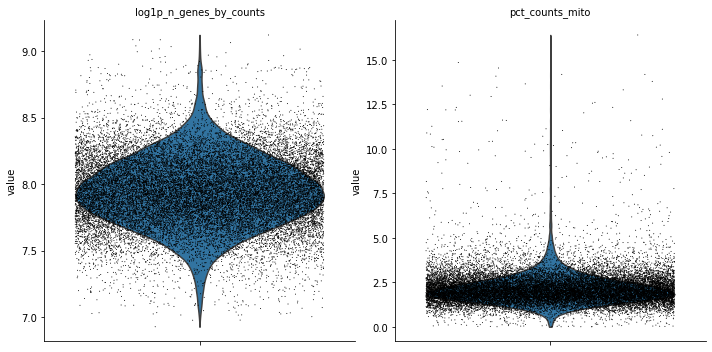

In [50]:
# step2. plotting the qc metrics
sc.pl.violin(adata_Neur1, ['log1p_n_genes_by_counts',  'pct_counts_mito'],
            jitter=0.4, multi_panel=True)

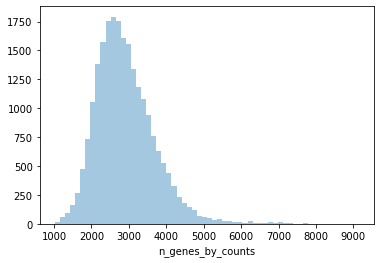

In [51]:
#step 3.we come up with thresholding decsions for genes for the FPP cells

p6 = sb.distplot(adata_Neur1.obs['n_genes_by_counts'], kde=False, bins=60)
plt.show()

In [52]:
#QC 2 - cell level - remove cells with high mito fraction

print('Number of cells before MT filter: {:d}'.format(adata_Neur1.n_obs))
adata_Neur1 = adata_Neur1[adata_Neur1.obs['pct_counts_mito'] < 5]
print('Number of cells after MT filter: {:d}'.format(adata_Neur1.n_obs))

Number of cells before MT filter: 22674
Number of cells after MT filter: 22392


In [53]:
#QC -3 - gene level

#Filter genes that are not expressed in more than 20 cells in the NB cells
print('Total number of genes: {:d}'.format(adata_Neur1.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_Neur1, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata_Neur1.n_vars))

Total number of genes: 32738


Trying to set attribute `.var` of view, copying.


Number of genes after cell filter: 18450


In [54]:
# normalization 
# The simplest way to normalize this data is to convert it to counts per million (CPM) by dividing each row by a size factor (the sum of all counts in the row), then multiplying by 1,000,000. Note that this method assumes that each cell originally contained the same amount of RNA.
adata_Neur1_cpm = adata_Neur1.copy() # apply this to a copy so we can compare methods
adata_Neur1_cpm.raw = adata_Neur1_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_Neur1_cpm, 
                         counts_per_cell_after=1e6)

In [55]:
# log transformation 
sc.pp.log1p(adata_Neur1_cpm)
adata_Neur1_cpm

AnnData object with n_obs × n_vars = 22392 × 18450
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p'
    obsm: 'X_umap'

In [56]:
# aggregate the normalized and log-transformed data for per gene per individual

means = pd.DataFrame(index=adata_Neur1_cpm.var_names)
for k, indices in adata_Neur1.obs.groupby("donor_id").indices.items():
    means[k] = np.ravel(adata_Neur1_cpm.X[indices].mean(axis=0))
    

In [57]:
df = means

In [58]:
df.to_csv("Neur1_NONE.csv")

In [59]:
#let's subset a specific celltype 
#subsample celltype
selected_celltype = ['U_Neur3']
adata_Neur3 = adata[adata.obs['celltype'].isin(selected_celltype),: ]
adata_Neur3

View of AnnData object with n_obs × n_vars = 7250 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    obsm: 'X_umap'

In [60]:
selected_tr = ['ROT']
adata_Neur3 = adata_Neur3[adata_Neur3.obs['treatment'].isin(selected_tr),: ]
adata_Neur3

View of AnnData object with n_obs × n_vars = 3093 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    obsm: 'X_umap'

In [61]:
# step1.calclate qc metrics 
adata_Neur3.var['mito'] = [x.startswith('MT-') for x in adata.var.index] 
sc.pp.calculate_qc_metrics(adata_Neur3, inplace=True, qc_vars=['mito'])

Trying to set attribute `.var` of view, copying.


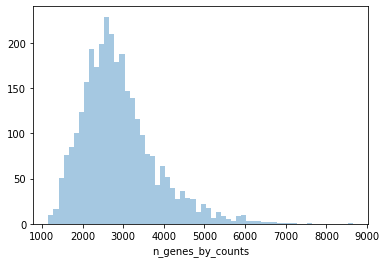

In [62]:
#step 3.we come up with thresholding decsions for genes for the FPP cells

p6 = sb.distplot(adata_Neur3.obs['n_genes_by_counts'], kde=False, bins=60)
plt.show()

In [63]:
#QC 2 - cell level - remove cells with high mito fraction

print('Number of cells before MT filter: {:d}'.format(adata_Neur3.n_obs))
adata_Neur3 = adata_Neur3[adata_Neur3.obs['pct_counts_mito'] < 5]
print('Number of cells after MT filter: {:d}'.format(adata_Neur3.n_obs))

Number of cells before MT filter: 3093
Number of cells after MT filter: 3053


In [64]:
#QC -3 - gene level

#Filter genes that are not expressed in more than 20 cells in the NB cells
print('Total number of genes: {:d}'.format(adata_Neur3.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_Neur3, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata_Neur3.n_vars))

Total number of genes: 32738


Trying to set attribute `.var` of view, copying.


Number of genes after cell filter: 15231


In [65]:
# normalization 
# The simplest way to normalize this data is to convert it to counts per million (CPM) by dividing each row by a size factor (the sum of all counts in the row), then multiplying by 1,000,000. Note that this method assumes that each cell originally contained the same amount of RNA.
adata_Neur3_cpm = adata_Neur3.copy() # apply this to a copy so we can compare methods
adata_Neur3_cpm.raw = adata_Neur3_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_Neur3_cpm, 
                         counts_per_cell_after=1e6)

In [66]:
# log transformation 
sc.pp.log1p(adata_Neur3_cpm)
adata_Neur3_cpm

AnnData object with n_obs × n_vars = 3053 × 15231
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p'
    obsm: 'X_umap'

In [67]:
# aggregate the normalized and log-transformed data for per gene per individual

means = pd.DataFrame(index=adata_Neur3_cpm.var_names)
for k, indices in adata_Neur3.obs.groupby("donor_id").indices.items():
    means[k] = np.ravel(adata_Neur3_cpm.X[indices].mean(axis=0))
   

In [68]:
df = means

In [69]:
df.to_csv("Neur3_ROT.csv")

In [70]:
#let's subset a specific celltype 
#subsample celltype
selected_celltype = ['U_Neur3']
adata_Neur3 = adata[adata.obs['celltype'].isin(selected_celltype),: ]
adata_Neur3

View of AnnData object with n_obs × n_vars = 7250 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    obsm: 'X_umap'

In [71]:
selected_tr = ['NONE']
adata_Neur3 = adata_Neur3[adata_Neur3.obs['treatment'].isin(selected_tr),: ]
adata_Neur3

View of AnnData object with n_obs × n_vars = 4157 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    obsm: 'X_umap'

In [72]:
# step1.calclate qc metrics 
adata_Neur3.var['mito'] = [x.startswith('MT-') for x in adata.var.index] 
sc.pp.calculate_qc_metrics(adata_Neur3, inplace=True, qc_vars=['mito'])

Trying to set attribute `.var` of view, copying.


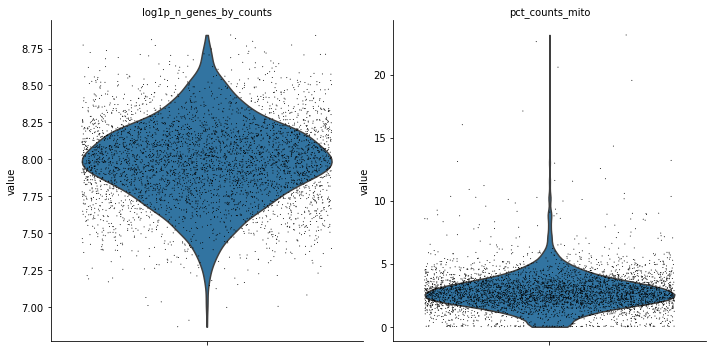

In [73]:
# step2. plotting the qc metrics
sc.pl.violin(adata_Neur3, ['log1p_n_genes_by_counts',  'pct_counts_mito'],
            jitter=0.4, multi_panel=True)

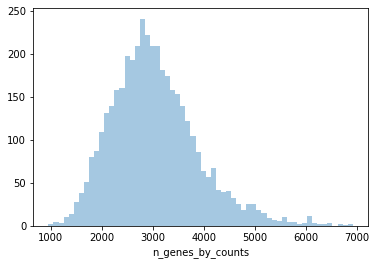

In [74]:
#step 3.we come up with thresholding decsions for genes for the FPP cells

p6 = sb.distplot(adata_Neur3.obs['n_genes_by_counts'], kde=False, bins=60)
plt.show()

In [75]:
#QC 2 - cell level - remove cells with high mito fraction

print('Number of cells before MT filter: {:d}'.format(adata_Neur3.n_obs))
adata_Neur3 = adata_Neur3[adata_Neur3.obs['pct_counts_mito'] < 5]
print('Number of cells after MT filter: {:d}'.format(adata_Neur3.n_obs))

Number of cells before MT filter: 4157
Number of cells after MT filter: 3934


In [76]:
#QC -3 - gene level

#Filter genes that are not expressed in more than 20 cells in the NB cells
print('Total number of genes: {:d}'.format(adata_Neur3.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_Neur3, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata_Neur3.n_vars))

Total number of genes: 32738


Trying to set attribute `.var` of view, copying.


Number of genes after cell filter: 15906


In [77]:
# normalization 
# The simplest way to normalize this data is to convert it to counts per million (CPM) by dividing each row by a size factor (the sum of all counts in the row), then multiplying by 1,000,000. Note that this method assumes that each cell originally contained the same amount of RNA.
adata_Neur3_cpm = adata_Neur3.copy() # apply this to a copy so we can compare methods
adata_Neur3_cpm.raw = adata_Neur3_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_Neur3_cpm, 
                         counts_per_cell_after=1e6)

In [78]:
# log transformation 
sc.pp.log1p(adata_Neur3_cpm)
adata_Neur3_cpm

AnnData object with n_obs × n_vars = 3934 × 15906
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p'
    obsm: 'X_umap'

In [79]:
# aggregate the normalized and log-transformed data for per gene per individual

means = pd.DataFrame(index=adata_Neur3_cpm.var_names)
for k, indices in adata_Neur3.obs.groupby("donor_id").indices.items():
    means[k] = np.ravel(adata_Neur3_cpm.X[indices].mean(axis=0))
    

In [80]:
df = means

In [81]:
df.to_csv("Neur3_NONE.csv")

In [82]:
#let's subset a specific celltype 
#subsample celltype
selected_celltype = ['U_Neur3']
adata_Neur3 = adata[adata.obs['celltype'].isin(selected_celltype),: ]
adata_Neur3

View of AnnData object with n_obs × n_vars = 7250 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    obsm: 'X_umap'

In [83]:
selected_tr = ['ROT']
adata_Neur3 = adata_Neur3[adata_Neur3.obs['treatment'].isin(selected_tr),: ]
adata_Neur3

View of AnnData object with n_obs × n_vars = 3093 × 32738
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment'
    obsm: 'X_umap'

In [84]:
# step1.calclate qc metrics 
adata_Neur3.var['mito'] = [x.startswith('MT-') for x in adata.var.index] 
sc.pp.calculate_qc_metrics(adata_Neur3, inplace=True, qc_vars=['mito'])

Trying to set attribute `.var` of view, copying.


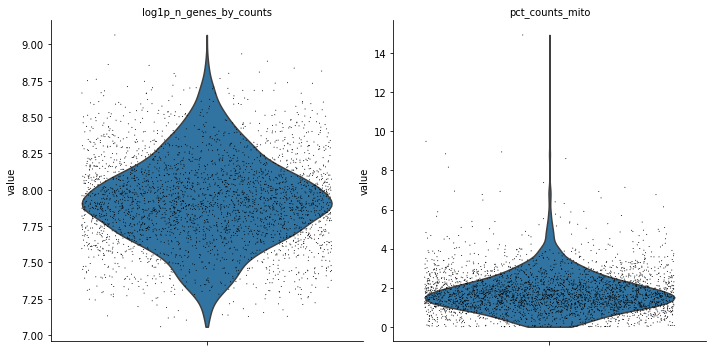

In [85]:
# step2. plotting the qc metrics
sc.pl.violin(adata_Neur3, ['log1p_n_genes_by_counts',  'pct_counts_mito'],
            jitter=0.4, multi_panel=True)

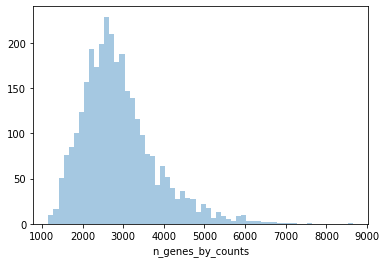

In [86]:
#step 3.we come up with thresholding decsions for genes for the FPP cells

p6 = sb.distplot(adata_Neur3.obs['n_genes_by_counts'], kde=False, bins=60)
plt.show()

In [87]:
#QC 2 - cell level - remove cells with high mito fraction

print('Number of cells before MT filter: {:d}'.format(adata_Neur3.n_obs))
adata_Neur3 = adata_Neur3[adata_Neur3.obs['pct_counts_mito'] < 5]
print('Number of cells after MT filter: {:d}'.format(adata_Neur3.n_obs))

Number of cells before MT filter: 3093
Number of cells after MT filter: 3053


In [88]:
#QC -3 - gene level

#Filter genes that are not expressed in more than 20 cells in the NB cells
print('Total number of genes: {:d}'.format(adata_Neur3.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_Neur3, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata_Neur3.n_vars))

Trying to set attribute `.var` of view, copying.


Total number of genes: 32738
Number of genes after cell filter: 15231


In [89]:
# normalization 
# The simplest way to normalize this data is to convert it to counts per million (CPM) by dividing each row by a size factor (the sum of all counts in the row), then multiplying by 1,000,000. Note that this method assumes that each cell originally contained the same amount of RNA.
adata_Neur3_cpm = adata_Neur3.copy() # apply this to a copy so we can compare methods
adata_Neur3_cpm.raw = adata_Neur3_cpm # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_Neur3_cpm, 
                         counts_per_cell_after=1e6)

In [90]:
# log transformation 
sc.pp.log1p(adata_Neur3_cpm)
adata_Neur3_cpm

AnnData object with n_obs × n_vars = 3053 × 15231
    obs: 'sample_index', 'sample_id', 'donor_id', 'cluster_id', 'celltype', 'time_point', 'pool_id', 'treatment', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p'
    obsm: 'X_umap'

In [91]:
# aggregate the normalized and log-transformed data for per gene per individual

means = pd.DataFrame(index=adata_Neur3_cpm.var_names)
for k, indices in adata_Neur3.obs.groupby("donor_id").indices.items():
    means[k] = np.ravel(adata_Neur3_cpm.X[indices].mean(axis=0))
    

In [92]:
df = means

In [93]:
df.to_csv("Neur3_ROT.csv")

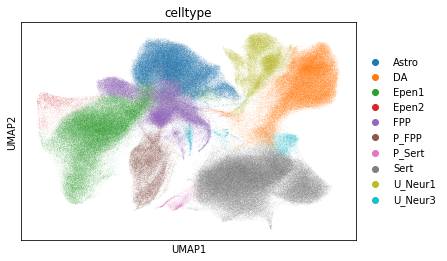

In [94]:
# now let's do the same for the other cell type - PFPP
# since this data has been already clustered and annotated- let's plot the umap plot 
plotting_fcn = sc.pl.umap
plotting_fcn(adata, color='celltype')